Find the average change in BTD value for each pixel, compare between FLC scene and non-FLC scene.

In [14]:
import xarray as xr
import pickle
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import goes_grid_convert as ggc
import os

In [16]:
date = "20220523"

path = "/home/jturner/false_low_clouds_2023/Static_Features/estimation_data"

static_features_data = "/home/jturner/false_low_clouds_2023/Static_Features/"+date

In [3]:
#---Gulf Stream
region = "gulfstream"
min_lon = -83
min_lat = 26
max_lon = -51
max_lat = 50

In [4]:
file = open(path+"/"+date+"_static_elements_"+region, 'rb')
BTD = pickle.load(file)
file.close()

In [5]:
data_07 = xr.open_dataset('/home/jturner/false_low_clouds_2023/Static_Features/sample_data/OR_ABI-L1b-RadF-M6C07_G16_s20222570500207_e20222570509526_c20222570509568.nc')

In [6]:
ds_07 = ggc.calc_latlon(data_07)

lats = (min_lat, max_lat)
lons = (min_lon, max_lon)

((x1,x2), (y1, y2)) = ggc.get_xy_from_latlon(ds_07, lats, lons)

subset_07 = ds_07.sel(x=slice(x1, x2), y=slice(y2, y1))

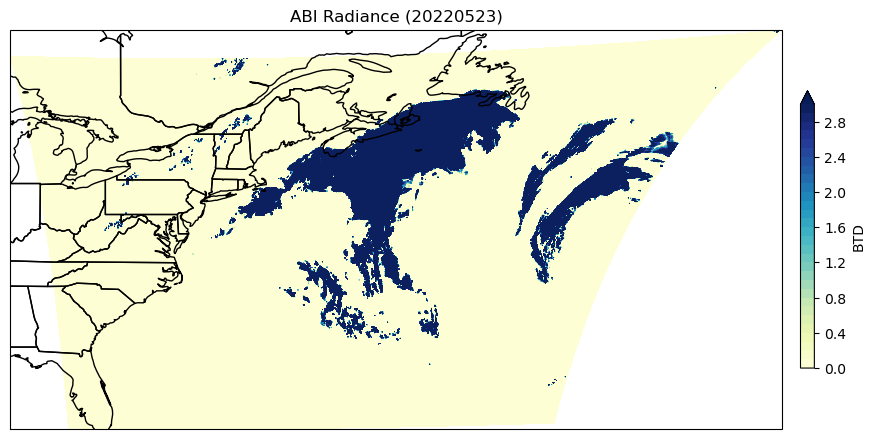

In [7]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.YlGnBu
#levels = np.linspace(np.amin(BTD), np.amax(BTD), 31)
levels = np.linspace(0, 3, 31)

c=ax.contourf(subset_07.Rad.lon, subset_07.Rad.lat, BTD, cmap=cmap, levels=levels, extend='max')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('ABI Radiance ('+date+')')
clb.set_label('BTD')

ax.add_feature(cfeature.STATES)

## Creating the Static Elements for the date
* Takes a few minutes to run
* Only needed if dataset is not created within Static_Features/estimation_data

In [22]:
#--- Initialize the 3D array with zeroes


BTD_prod = [[ [0]*len(BTD[0]) for i in range(len(BTD))] for k in range(len(os.listdir(static_features_data)))]

Not yet formulated for new function

In [ ]:
#--- For each of the files in dir, crop and calculate BTD

for filename in os.listdir(root):
    
    #--- To avoid duplicates, loop through only Band 07 data
    if filename[0:21] == 'OR_ABI-L1b-RadF-M6C07':
                    
        data_07 = xr.open_dataset(root+'/'+filename)
        
        print('Processing 07 band for '+filename[27:31]+'-'+filename[31:34]+' '+filename[34:36]+':'+filename[36:38])

        ds_07 = calc_latlon(data_07)

        ((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_07, lats, lons)

        subset_07 = ds_07.sel(x=slice(x1, x2), y=slice(y2, y1))
        
        #--- Search for corresponding Band 14 file:
        files = os.listdir(root) 
        pattern = 'OR_ABI-L1b-RadF-M6C14*'+filename[27:38]+'*.nc'
        filename_14 = str(fnmatch.filter(files, pattern)[0])
            
        data_14 = xr.open_dataset(root+'/'+filename_14)
        
        print('Processing 14 band for '+filename_14[27:31]+'-'+filename_14[31:34]+' '+filename_14[34:36]+':'+filename_14[36:38])

        ds_14 = calc_latlon(data_14)

        ((x1,x2), (y1, y2)) = get_xy_from_latlon(ds_14, lats, lons)

        subset_14 = ds_14.sel(x=slice(x1, x2), y=slice(y2, y1))
        
        #--- Calculate BTD and take product of the data over time
        T_07 = (subset_07.planck_fk2/(np.log((subset_07.planck_fk1/subset_07.Rad)+1)) - subset_07.planck_bc1)/subset_07.planck_bc2
        T_14 = (subset_14.planck_fk2/(np.log((subset_14.planck_fk1/subset_14.Rad)+1)) - subset_14.planck_bc1)/subset_14.planck_bc2

        BTD = T_14 - T_07
        
        
        #--- set negative values to zero
        BTD_lim = np.where(BTD < 0, 0, BTD)
        
        #--- take product of new time step against previous
        BTD_prod = BTD_prod*BTD_lim
        
        #--- limit to between zero and 3
        #--- this slightly dulls the sharp edges of the FLC signal
        BTD_prod = np.where(BTD_prod > 3, 3, BTD_prod)